In [10]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

In [2]:
# Directories training and testing data for load ans shuffle
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'


train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

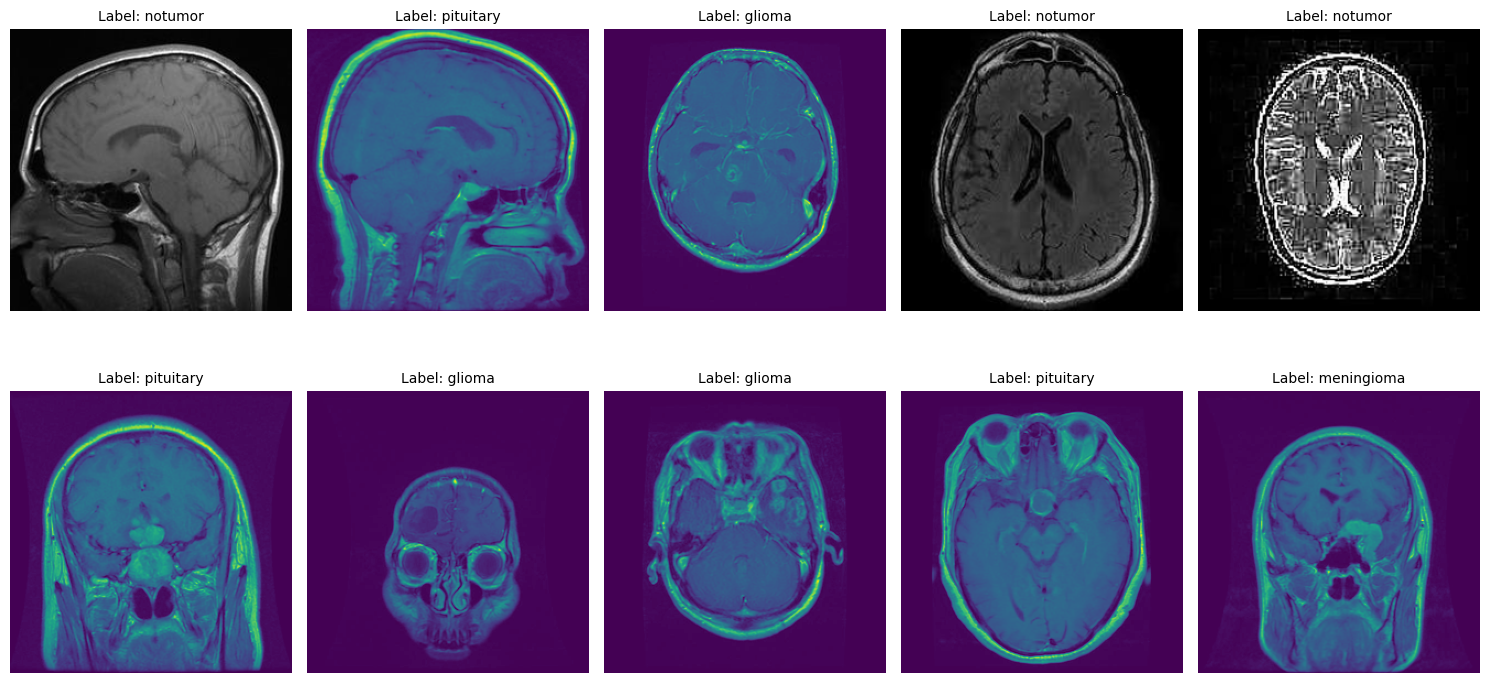

In [3]:
random_indices = random.sample(range(len(train_paths)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((256,256))  

    axes[i].imshow(img)
    axes[i].axis('off')  
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [4]:
def augment_image(image):
    image= Image.fromarray(np.uint8(image))
    image= ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image= ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image= np.array(image)
    return image

def open_images(paths):
    images = []
    for path in paths:
        image= load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image= augment_image(image)
        images.append(image)
    return np.array(images)

def encode_label(labels):
    unique_labels= os.listdir(train_dir)
    encoded= [unique_labels.index(label) for label in labels]
    return np.array(encoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths= paths[i:i + batch_size]
            batch_images= open_images(batch_paths) 
            batch_labels= labels[i:i + batch_size]
            batch_labels= encode_label(batch_labels)  
            yield batch_images, batch_labels

In [28]:
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable= False

base_model.layers[-1].trainable= True
base_model.layers[-2].trainable= True
base_model.layers[-3].trainable= True
base_model.layers[-4].trainable= True

model= Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation= 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation= 'softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

batch_size = 20
steps = int(len(train_paths) / batch_size) 
epochs = 20

history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),epochs=epochs, steps_per_epoch=steps)

Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 1.6357 - sparse_categorical_accuracy: 0.5888
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - loss: 0.5244 - sparse_categorical_accuracy: 0.8097
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 0.3495 - sparse_categorical_accuracy: 0.8766
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 0.2796 - sparse_categorical_accuracy: 0.9021
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.2123 - sparse_categorical_accuracy: 0.9288
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.1929 - sparse_categorical_accuracy: 0.9345
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.1633 - sparse_categorical_accuracy: 0.9463
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.9512
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.9606
Epoch 10/20
285/285 ━━━━━━━━━━━━━━━━━

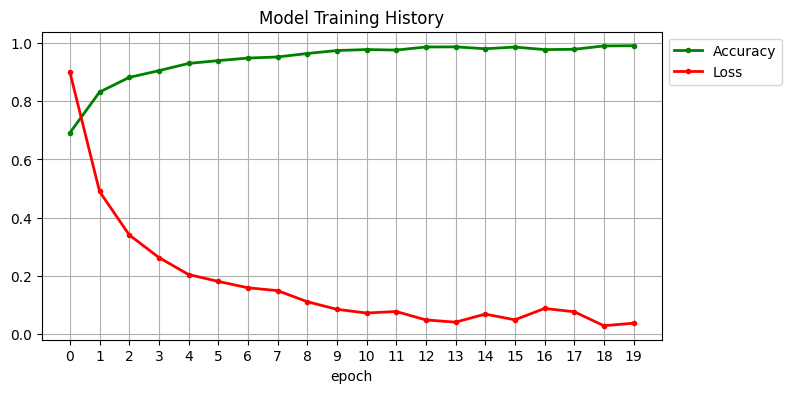

In [29]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [30]:
test_images = open_images(test_paths) 
test_labels_encoded = encode_label(test_labels)  

test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 237ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       1.00      1.00      1.00       405
           2       0.97      0.93      0.95       306
           3       0.96      0.98      0.97       300

    accuracy                           0.98      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311



# ROC  curve plot

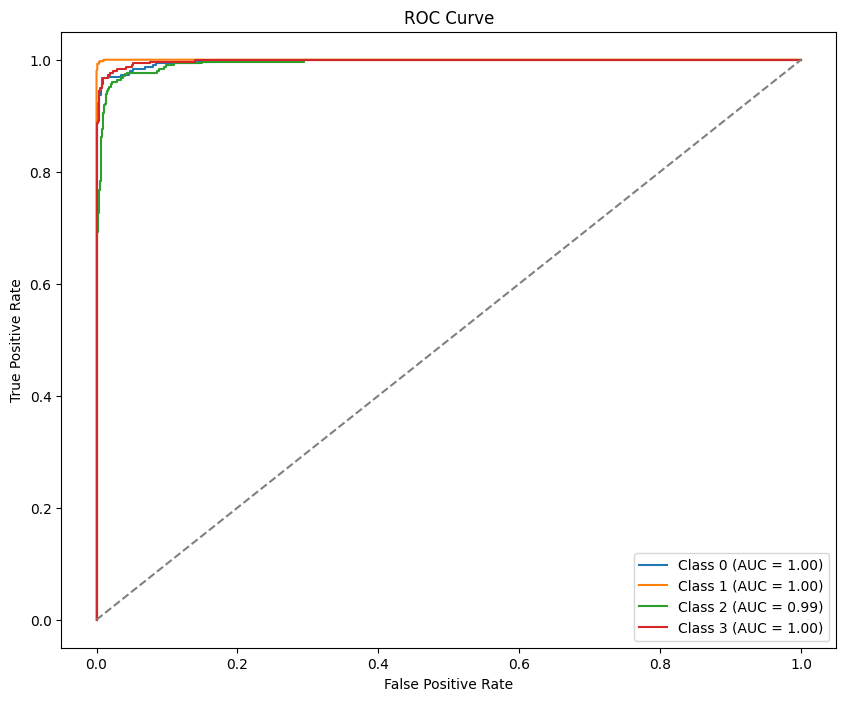

In [18]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  


fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [32]:
model.save('model.h5')

In [33]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [34]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


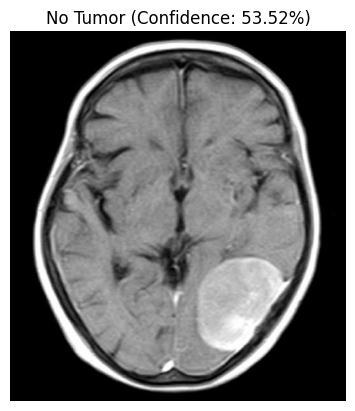

In [35]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


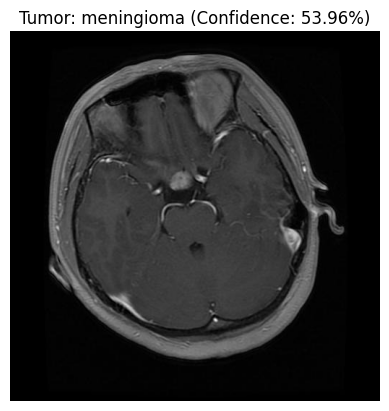

In [36]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0013.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)